# Import packages
Import the following packages which required for data processing and building tha model

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Create Category's
Create 2 category's that we have to classify

In [2]:
class_names = ['men', 'women']
class_names_label = {'men': 0,
                    'women' : 1
                    }
nb_classes = 2

# Data Preprocessong
Load all the training images and convert it into numbers

In [3]:
size = (200,200)
output = []
directory = "../input/healthsignzgenderclassification/data/Training Set"

images = []
labels = []
for folder in os.listdir(directory):
    
    curr_label = class_names_label[folder]
    for file in os.listdir(directory + "/" + folder):
        img_path = directory + "/" + folder + "/" + file
        if not file.endswith('gif'): 
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
        else:
            curr_img = load_img(img_path, target_size=size)
            curr_img = img_to_array(curr_img)
        images.append(curr_img)
        labels.append(curr_label)
images, labels = shuffle(images, labels)     ### Shuffle the data !!!
images = np.array(images, dtype = 'float32') ### Our images
labels = np.array(labels, dtype = 'int32')   ### From 0 to num_classes-1!

# Normalize the data
Scale the data set

In [4]:
images = np.array(images) / 255.0

# Create CV dataset

In [5]:
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.2, random_state=50)

# Reshape the data
Reshape the dataset in the format which is accepted by the algorithm

In [6]:
trainX = np.array(trainX).reshape(-1, 200,200,3)
trainY = np.array(trainY)
testX = np.array(testX).reshape(-1, 200,200,3)
testY = np.array(testY)

# Explore the dataset

In [7]:
print ("Number of training examples: " + str(trainX.shape[0]))
print ("Number of testing examples: " + str(testX.shape[0]))
print ("Each image is of size: " + str(trainX.shape[1:]))

Number of training examples: 2112
Number of testing examples: 528
Each image is of size: (200, 200, 3)


# Train the model
Tried with different combinations of hyper paramters and selected the following parameters which gives better prediction result and avoids the overfitting problem

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

# Data Augmentaion
Applied data generator to generate diversed images from the existing images such cropped, padding and horizantol flipping. Tried with the different combinitions and selected the best values based on the accuracy

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )

# Train the model

In [10]:
model_fit = model.fit_generator(
    train_datagen.flow(trainX, trainY, batch_size=32),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // 64,
    epochs=100)

Epoch 1/100
33/33 [==============================] - 10s 302ms/step - loss: 0.6766 - acc: 0.5795 - val_loss: 0.6912 - val_acc: 0.5511
Epoch 2/100
33/33 [==============================] - 8s 242ms/step - loss: 0.6715 - acc: 0.5767 - val_loss: 0.6647 - val_acc: 0.5701
Epoch 3/100
33/33 [==============================] - 8s 252ms/step - loss: 0.6731 - acc: 0.5881 - val_loss: 0.6736 - val_acc: 0.5758
Epoch 4/100
33/33 [==============================] - 8s 246ms/step - loss: 0.6638 - acc: 0.6042 - val_loss: 0.6693 - val_acc: 0.5511
Epoch 5/100
33/33 [==============================] - 8s 249ms/step - loss: 0.6695 - acc: 0.6032 - val_loss: 0.6558 - val_acc: 0.6174
Epoch 6/100
33/33 [==============================] - 8s 243ms/step - loss: 0.6582 - acc: 0.6307 - val_loss: 0.6573 - val_acc: 0.6098
Epoch 7/100
33/33 [==============================] - 8s 244ms/step - loss: 0.6426 - acc: 0.6496 - val_loss: 0.6410 - val_acc: 0.6231
Epoch 8/100
33/33 [==============================] - 8s 242ms/step -

# Visualize accuracy over different epochs
As per the validation accuracy there is no overfitting however the validation loss is little more when epoch approaches 100 

<Figure size 432x288 with 0 Axes>

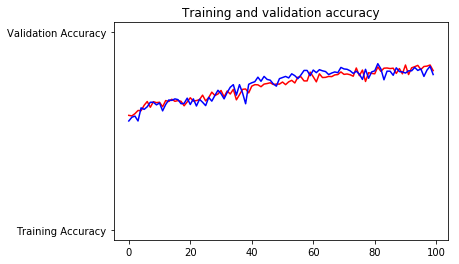

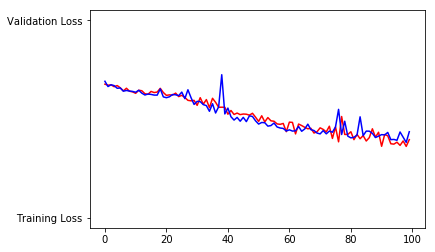

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=model_fit.history['acc']
val_acc=model_fit.history['val_acc']
loss=model_fit.history['loss']
val_loss=model_fit.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

# Check model performance

In [12]:
import numpy as np
from keras.preprocessing import image
fn = '2816.jpg'
path = '../input/healthsignzgenderclassification/data/Testing Set/' + fn
if not fn.endswith('gif'): 
    curr_img = cv2.imread(path)
    curr_img = cv2.resize(curr_img, size)
else:
    curr_img = load_img(path, target_size=size)
    curr_img = img_to_array(curr_img)
images = np.array(curr_img, dtype = 'float32')
images = np.array(curr_img) / 255.0
images = np.array(images).reshape(-1, 200,200,3)
classes = model.predict(images, batch_size=32)
print(classes)
print(classes[0])
if classes[0]>0.5:
    print(fn + " is a women")
else:
    print(fn + " is a men")

[[0.27938867]]
[0.27938867]
2816.jpg is a men


In [13]:
test_dir = "../input/healthsignzgenderclassification/data/Testing Set/"

pred = []
id_line = []
def create_test1_data(path):
    for file in os.listdir(path):
        id_line.append(file.split(".")[0])
        img_path = path + "/" + file
        if not img_path.endswith('gif'): 
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
        else:
            curr_img = load_img(img_path, target_size=size)
            curr_img = img_to_array(curr_img)
        images = np.array(curr_img, dtype = 'float32')
        images = np.array(curr_img) / 255.0
        #images = np.array(images).reshape(-1, 200,200,3)
        #classes = model.predict(images, batch_size=32)
        
        images = np.array(images).reshape(-1, 200,200,3)
        classes = model.predict(images, batch_size=32)
        #print(classes)
        #print(classes[0])
        if classes[0]>0.5:
            pred.append("W")
        else:
            pred.append("M")
create_test1_data(test_dir)

submission_df = pd.DataFrame({'id':id_line, 'label':pred})
submission_df.to_csv("../input/healthsignzgenderclassification/data/submission.csv", index=False)

OSError: [Errno 30] Read-only file system: '../input/healthsignzgenderclassification/data/submission.csv'

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(submission_df.sort_values(by=['id']))

       id label
286  2001     M
554  2002     W
131  2003     M
647  2006     M
347  2008     M
423  2010     M
127  2011     M
514  2012     M
628  2014     W
395  2015     W
456  2016     M
541  2018     M
274  2019     M
645  2022     W
685  2023     W
65   2024     W
305  2025     M
350  2028     M
61   2030     M
114  2031     M
15   2033     W
501  2034     M
26   2035     M
40   2036     M
443  2037     W
191  2039     W
225  2040     M
205  2043     W
303  2045     M
602  2048     M
373  2049     M
299  2050     M
644  2051     M
585  2052     M
218  2054     M
144  2055     W
250  2056     W
149  2057     W
196  2059     M
117  2062     M
18   2063     M
607  2065     W
660  2066     W
401  2072     M
556  2073     W
596  2074     W
17   2076     M
634  2079     W
180  2080     W
235  2081     W
377  2082     M
173  2084     W
241  2085     W
227  2087     M
35   2089     M
136  2091     W
7    2092     M
75   2094     M
59   2096     M
232  2097     M
296  2098     W
89   210